### MAST30034: Applied Data Science Project 1
---
# Preprocessing Part 2: Aggregating Data by MMWR Week
#### Xavier Travers (1178369)

Aggregate all the data by MMWR week (defined [here](https://ndc.services.cdc.gov/wp-content/uploads/MMWR_Week_overview.pdf)).
This means counting trips to and from each of the boroughs per month.
This is done for each of the taxi types.

In [1]:
# imports used throughout this notebook
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
import os
import sys
import re
from itertools import chain

# add homemade helpers
sys.path.insert(1, '../../scripts')
import helpers.plot_helpers as ph

# path where the data files are stored
DATA_PATH = '../../data'

In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName('MAST30034 XT Project 1')
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.sql.repl.eagerEval.enabled', True) 
    .config('spark.sql.parquet.cacheMetadata', 'true')
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/08/20 19:20:56 WARN Utils: Your hostname, Polaris resolves to a loopback address: 127.0.1.1; using 172.18.201.167 instead (on interface eth0)
22/08/20 19:20:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/20 19:20:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# read in the pickup data
tlc_pu_df = spark.read.parquet(f'{DATA_PATH}/curated/tlc/aggregated/yellow/by_pu')
tlc_pu_df.limit(5)

week_year,week_month,week_ending,week_index,timeline,pu_borough,population,num_trips,num_pc_trips,num_p100k_trips,tot_passengers,avg_passengers,avg_trip_distance
2020,9,2020-09-19,142,2,Brooklyn,2727393.0,2290,8.396296389995868E-4,83.96296389995868,3082.0,1.3458515283842796,2.986074235807861
2021,2,2021-02-20,164,2,Manhattan,1576876.0,291970,0.1851572349379406,18515.72349379406,414197.0,1.4186286262287222,2.1355327944651585
2020,9,2020-09-19,142,2,Staten Island,495522.0,39,7.870488091346096E-5,7.870488091346096,39.0,1.0,31.242307692307694
2021,1,2021-01-09,158,2,Staten Island,493494.0,55,1.114501898705962E-4,11.14501898705962,57.0,1.0363636363636364,30.25254545454545
2020,9,2020-09-26,143,2,Bronx,1466438.0,904,6.164597480425358E-4,61.64597480425357,1189.0,1.3152654867256637,3.7580199115044266


In [4]:
# apply timeline 1 (analysis range)
tlc_pu_df = tlc_pu_df.where(F.col('timeline') == 1)

In [5]:
# convert the dataset into a pandas dataframe
tlc_pu_df = tlc_pu_df.toPandas()

### Trip Distances

In [6]:
# simple summary statistics (mean and variance)
print(f'''AVERAGE TRIP DISTANCES
MEAN = {tlc_pu_df['avg_trip_distance'].mean()}
VARIANCE = {tlc_pu_df['avg_trip_distance'].var()}''')

AVERAGE TRIP DISTANCES
MEAN = 9.379692800938965
VARIANCE = 88.40707888217084


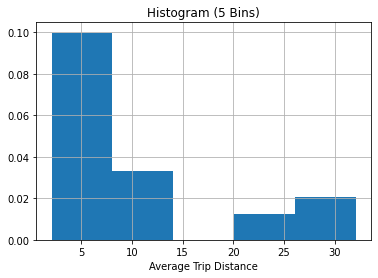

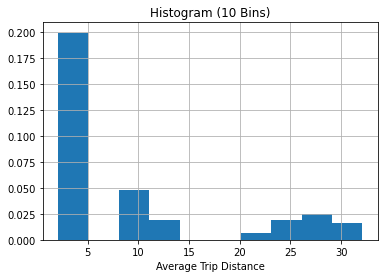

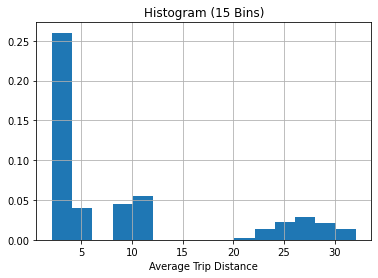

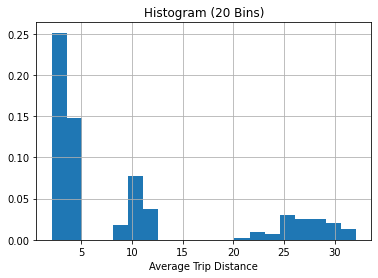

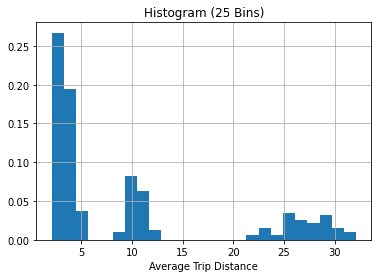

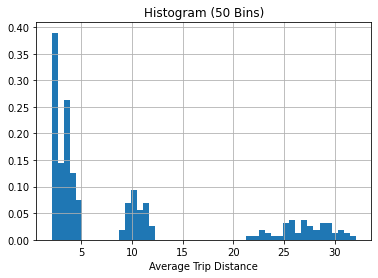

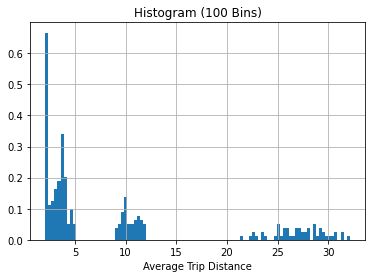

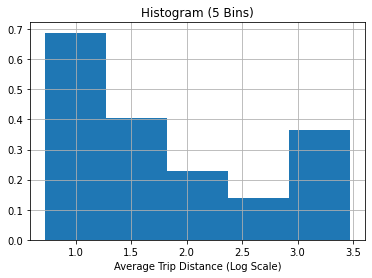

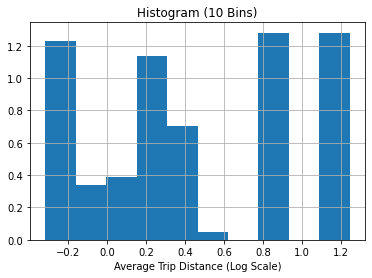

/home/digitaldata/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


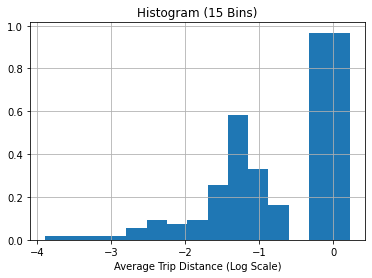

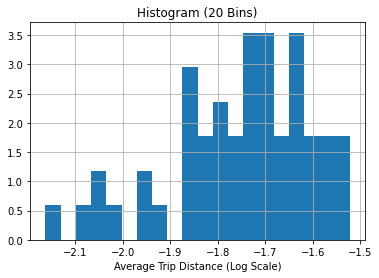

/home/digitaldata/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


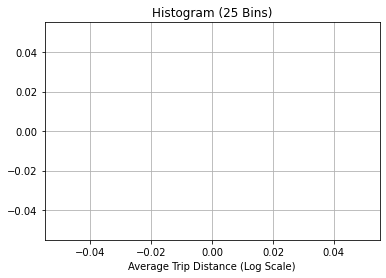

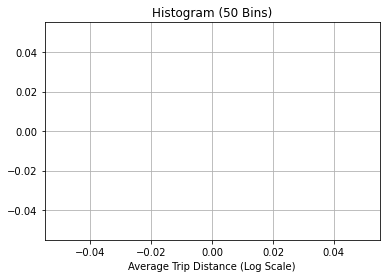

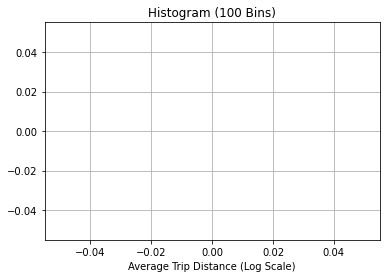

In [7]:
# plot the histogram of trip distances with different bin counts
for logx in [False, True]:
    for bins in [5, 10, 15, 20, 25, 50, 100]:
        ph.histogram(tlc_pu_df, 'avg_trip_distance', 
            'Average Trip Distance', bins, logx)

### Passenger Counts

In [8]:
# simple summary statistics (mean and variance)
print(f'''AVERAGE PASSENGER COUNTS
MEAN = {tlc_pu_df['avg_passengers'].mean()}
VARIANCE = {tlc_pu_df['avg_passengers'].var()}''')

AVERAGE PASSENGER COUNTS
MEAN = 1.3065771454604913
VARIANCE = 0.018610421658440575


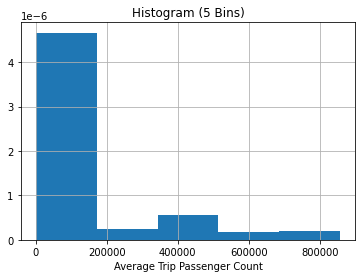

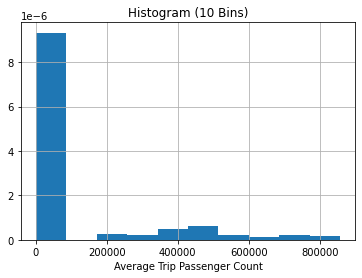

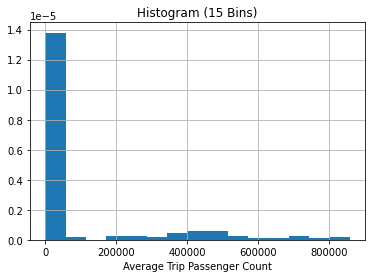

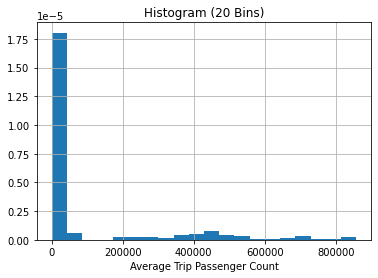

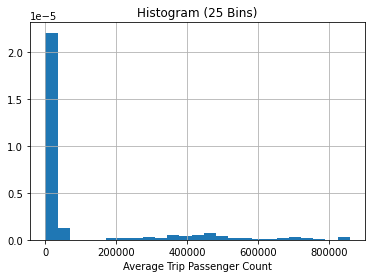

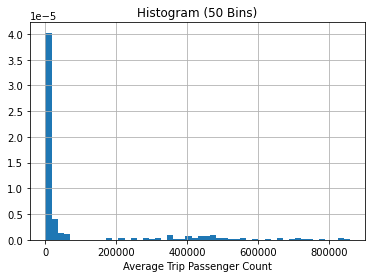

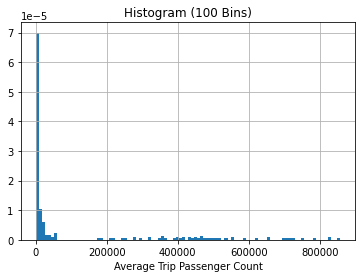

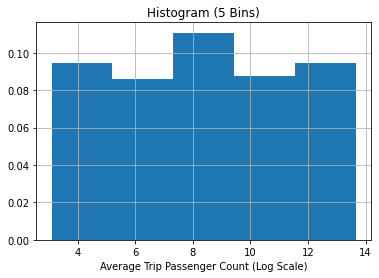

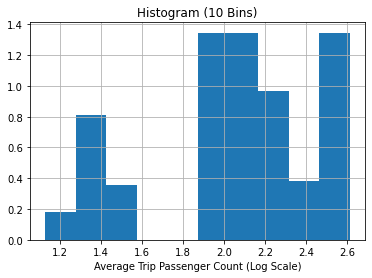

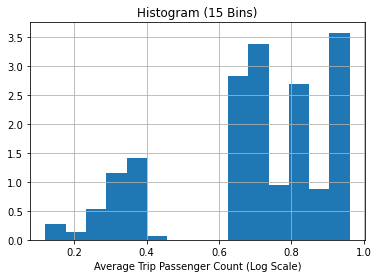

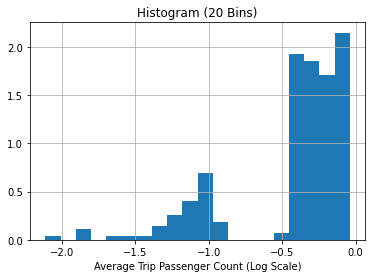

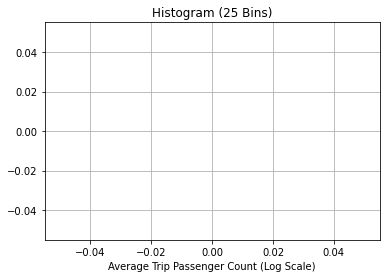

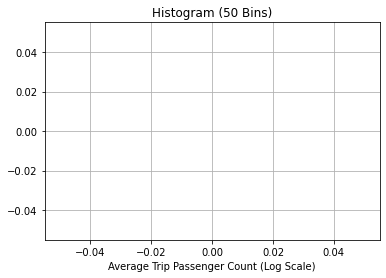

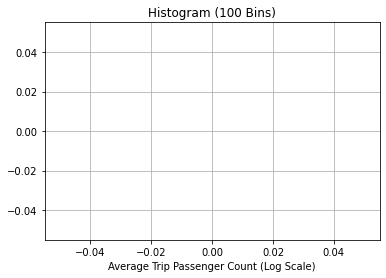

In [10]:
# plot the histogram of trip distances
for logx in [False, True]:
    for bins in [5, 10, 15, 20, 25, 50, 100]:
        ph.histogram(tlc_pu_df, 'tot_passengers',
            'Average Trip Passenger Count', bins, logx)